[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CyanideBoy/RDE-Project/blob/master/NLP-Reimplement/XAI-Methods/xai-innvestigate-demo.ipynb)

In [1]:
%tensorflow_version 1.4
!pip install innvestigate

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
!wget http://qwone.com/%7Ejason/20Newsgroups/20news-bydate.tar.gz

In [0]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

In [0]:
!gunzip GoogleNews-vectors-negative300.bin.gz 

In [0]:
!tar -xzf 20news-bydate.tar.gz

In [2]:
'''

Taken from https://github.com/Golbstein/pytorch_to_keras/blob/master/pytorch2keras.ipynb

'''

#%matplotlib inline

import torch
from keras import backend as K
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D
from keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt

from model import ConvNet
from CustomDataset import get_dataset

model = ConvNet(False)
model.cpu()
model.eval()
model.load_state_dict(torch.load('Model_quicksave4.pt'))

print(K.image_data_format())

with tf.device('/cpu:0'):
    inp = Input((None,300,1))
    x = Conv2D(800,(2,300),activation='relu', name='conv1')(inp)
    #print(x.shape)
    # Reshaping to (BCHW)
    #x = MaxPool2D((399,1))(x)
    x = GlobalMaxPool2D('channels_last')(x)
    # Reshaping to (BCHW)
    #x = Lambda(lambda x: K.permute_dimensions(x, (0, 3, 1, 2)))(x)
    #x = Flatten()(x)
    out = Dense(20,name='fc1')(x)
    k_model = Model(inp, out)


trained_weights = model.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    #print(x)
    #print(l)
    #print(x.find('.'))
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
channels_last



['conv1' 'fc1']






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 800)      480800    
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 800)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 20)                16020     
Total params: 496,820
Trainable params: 496,820
Non-trainable params: 0
_________________________________________________________________


In [3]:

#### Verify

dset = get_dataset('20news-bydate-train')
sample = dset.get_custom_matrix(243)
a,b,p = dset[243]
print(p)

20news-bydate-train/alt.atheism/53130


In [0]:
out = k_model.predict(sample[None,:,:,None])

In [0]:
p_out = model(torch.from_numpy(sample[None,None,:,:].astype('float32')))

max difference: 2.3841858e-07 
sum of difffernces: 5.811453e-07


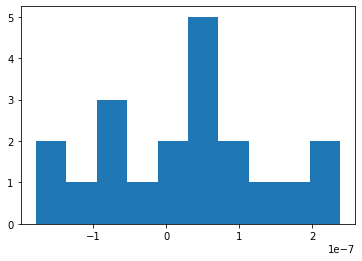

In [6]:
y = torch.from_numpy(out) - p_out
y = y.detach().numpy().flatten()
plt.hist(y);
print('max difference:', y.max(), '\nsum of difffernces:', y.sum())

In [7]:
print(out)
print(p_out)

[[ 0.3189879  -0.6008303  -0.5728302  -0.7731877  -0.38859674 -0.20001163
  -0.5081794  -0.69103324 -0.4941711  -0.38935563 -0.42388293 -0.49544993
  -0.6653334  -0.4798219  -0.38539904 -0.1295258  -0.51531065 -0.07424574
  -0.19288445 -0.18012317]]
tensor([[ 0.3190, -0.6008, -0.5728, -0.7732, -0.3886, -0.2000, -0.5082, -0.6910,
         -0.4942, -0.3894, -0.4239, -0.4954, -0.6653, -0.4798, -0.3854, -0.1295,
         -0.5153, -0.0742, -0.1929, -0.1801]], grad_fn=<AddmmBackward>)


In [8]:
K.floatx()

'float32'

In [0]:
import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

from matplotlib import cm, transforms

In [0]:
methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor']
kwargs = [{}, {}, {}, {}]

In [24]:
analyzers = []

for method, kws in zip(methods, kwargs):
    print(method)
    analyzer = innvestigate.create_analyzer(method, k_model, **kws)
    analyzer.fit(sample[None,:,:,None], batch_size=256, verbose=1)
    analyzers.append(analyzer)


gradient
lrp.z
lrp.alpha_2_beta_1
deep_taylor


/usr/local/lib/python3.6/dist-packages/innvestigate/analyzer/base.py:130: RuntimeWarning: This analyzer does not need to be trained. Still fit() is called.
  " Still fit() is called.", RuntimeWarning)


In [0]:
# This is a utility method visualizing the relevance scores of each word to the network's prediction. 
# one might skip understanding the function, and see its output first.
def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

In [51]:
from keras.layers import Softmax
import time

test_sample_indices = [224]

test_sample_preds = [None]*len(test_sample_indices)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_indices), len(analyzers), 1, dset.get_custom_matrix(test_sample_indices[0]).shape[0]])

for i, ridx in enumerate(test_sample_indices):
    #print(dset.get_custom_matrix(243).shape[0])
    x = dset.get_custom_matrix(ridx)
    #print(x.shape)
    #print(ridx)
    _,y,p = dset[ridx]
    t_start = time.time()
    x = x.reshape((1, -1, 300,1))    

    presm = k_model.predict_on_batch(x)[0] #forward pass without softmax
    prob = k_model.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    test_sample_preds[i] = y_hat
    print(p)
    
    for aidx, analyzer in enumerate(analyzers):

        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        #print(x.shape)
        #print(a.shape)
        analysis[i, aidx] = a
    t_elapsed = time.time() - t_start
    print('Review %d (%.4fs)'% (ridx, t_elapsed))

20news-bydate-train/alt.atheism/53098
Review 224 (0.0355s)


Review(id=224): In article 1qjfnv ogt horus.ap.mchp.sni.de frank D012S658.uucp Frank O'Dwyer wrote Does the term hero-worship mean anything to you Yes worshipping Jesus as the super-saver is indeed hero-worshipping of the grand scale . Worshipping Lenin that will make life pleasant for the working people is eh somehow similar or what . I understand that gods are defined to be supernatural not merely superhuman . The notion of Lenin was on the borderline of supernatural insights into how to change the world he was n't a communist God but he was the man who gave presents to kids during Christmas . Actually I agree . Things are always relative and you ca n't have a direct mapping between a movement and a cause . However the notion that communist Russia was somewhat the typical atheist country is only something that Robertson Tilton et rest would believe in . Those atheists were not True Unbelievers huh Do n't know what they were but they were fanatics indeed . Cheers Kent sandvik newton.a

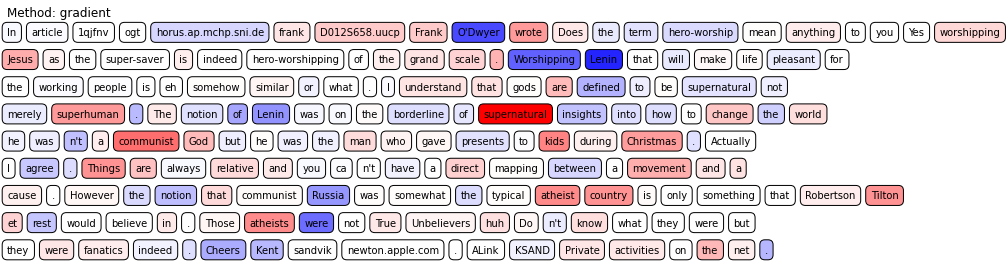

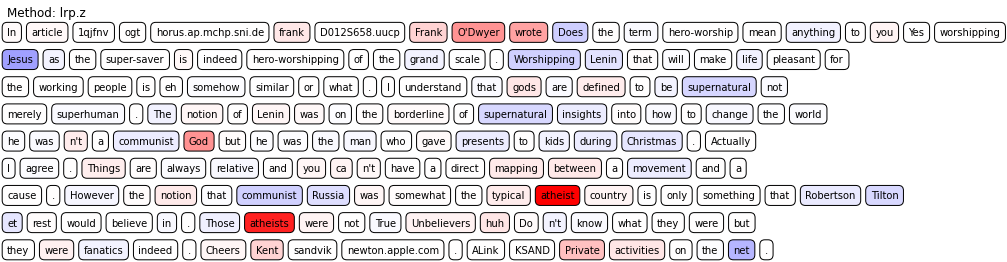

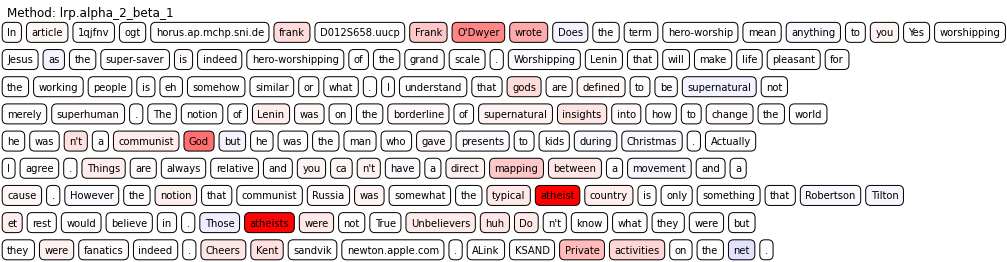

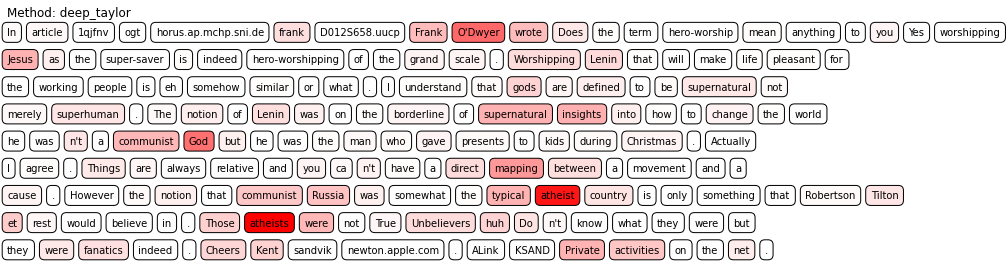

In [52]:
for i, idx in enumerate(test_sample_indices):

    words = dset.get_words_list(idx)
    
    print('Review(id=%d): %s' % (idx, ' '.join(words)))
    _,y_true,_2 = dset[idx]
    y_pred = test_sample_preds[i]

    print("Pred class : %s %s" %
          (y_pred, '✓' if y_pred == y_true else '✗ (%s)' % y_true)
         )
                                
    for j, method in enumerate(methods):
        plot_text_heatmap(words, analysis[i, j].reshape(-1), title='Method: %s' % method, verbose=0)
        plt.show()